# Udacity Capstone Project
# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

In [1]:
# load packages
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import ast

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploratory Data Analysis

### Portfolio

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [5]:
# one hot encode channels column
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [6]:
# one hot encode offer_type column
offer_types = pd.get_dummies(portfolio['offer_type'], prefix ='offer_type', prefix_sep='_')
portfolio = pd.concat([portfolio.drop(['offer_type','channels'],axis=1),offer_types],axis=1)

In [7]:
# final format
portfolio

,difficulty,duration,offer_id,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


### Profile

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.shape

(17000, 5)

In [10]:
profile.rename(columns={'id':'customer_id'},inplace=True)

In [11]:
# number of days since the user has been a member
today = pd.to_datetime(datetime.today().strftime('%Y%m%d'))
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
profile['days_as_member'] = (today - profile['became_member_on']) / np.timedelta64(1,'D')
profile = profile.drop(['became_member_on'], axis=1)

In [12]:
genders = pd.get_dummies(profile['gender'], prefix = "gender", prefix_sep = "_")
profile = pd.concat([profile, genders], axis=1)

In [13]:
profile.head()

,age,gender,customer_id,income,days_as_member,gender_F,gender_M,gender_O
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1875.0,0,0,0
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1722.0,1,0,0
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1360.0,0,0,0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1789.0,1,0,0
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,1702.0,0,0,0


In [14]:
# take a look at gender distribution
profile['gender'].value_counts(normalize=True)

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [15]:
# some customers don't have a gender value, thus only keep notna rows
profile = profile[profile['gender'].notna()]

In [16]:
# basic stats
profile.describe()

,age,income,days_as_member,gender_F,gender_M,gender_O
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1868.478988,0.413423,0.572277,0.014300
std,17.383705,21598.299410,419.205158,0.492464,0.494765,0.118729
min,18.000000,30000.000000,1346.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,1554.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,1704.000000,0.000000,1.000000,0.000000
75%,66.000000,80000.000000,2143.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,3169.000000,1.000000,1.000000,1.000000


In [17]:
# discrepancy between number of rows vs income
# some customers don't have an income value, thus only keep notna rows
profile = profile[profile['income'].notna()]

In [18]:
# shape after cleaning
profile.shape

(14825, 8)

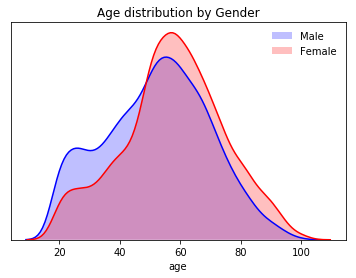

In [19]:
sns.distplot(profile[profile['gender']=='M']['age'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['age'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Age distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False)

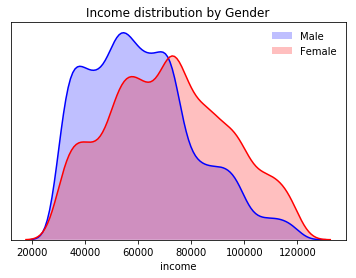

In [20]:
sns.distplot(profile[profile['gender']=='M']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['income'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Income distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False)

In [21]:
profile = profile.drop(['gender'], axis=1)

### Transcript

In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
transcript.rename(columns={'person':'customer_id'},inplace=True)

In [24]:
transcript.shape

(306534, 4)

In [25]:
# take a look at event distribution
transcript['event'].value_counts(normalize=True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [26]:
# format the value column
transcript['value'] = transcript['value'].apply(lambda x: ast.literal_eval(str(x)))

for col_name in ['amount', 'reward']:
    transcript[col_name] = transcript['value'].apply(lambda x: x[col_name] if col_name in x else None)

transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x \
                                                   else (x['offer id'] if 'offer id' in x else None))

# drop the original value column since we no longer need it
transcript.drop('value', axis=1, inplace=True)

# new data format
transcript.head()

,event,customer_id,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [27]:
# take a look at top offers
transcript['offer_id'].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    20241
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
f19421c1d4aa40978ebb69ca19b0e20d    19131
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
ae264e3637204a6fb9bb56bc8210ddfd    18062
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
2906b810c7d4411798c6938adc9daaa5    15767
5a8bc65990b245e5a138643cd4eb9837    14305
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
3f207df678b143eea3cee63160fa8bed    11761
Name: offer_id, dtype: int64

In [28]:
# take a loof at the time feature
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [29]:
# top 10 customers who have the highest records
transcript.groupby('customer_id')['time'].count().\
    reset_index(name='count').sort_values(['count'], ascending=False).head(10)

,customer_id,count
9942,94de646f7b6041228ca7dec82adb97d2,51
9465,8dbfa485249f409aa223a2130f40634a,49
6268,5e60c6aa3b834e44b822ea43a3efea26,48
13901,d0a80415b84c4df4908b8403b19765e3,48
8077,79d9d4f86aca4bed9290350fb43817c2,48
2582,28681c16026943e68f26feaccab0907f,46
12657,bd2cdd691aca4bb0a0e039979ee5de5c,46
11013,a42ed50acc4d4b25bca647c9e0b916ad,46
11938,b1f4ece7d49342628a9ed77aee2cde58,46
11470,ab25fd6fbd5040f880751921e4029757,44


In [30]:
def clean_transcript(transcript):
    
    offer_customer = transcript.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    offer_customer.reset_index(level=[0,1],inplace = True)
    
    offer_customer.fillna(0.0, inplace = True)
    
    # Determine which offers where successful - where offer completed and offer viewed  are greater than 1.
    # We can multiply the two columns together and replace any values > 0 with 1.
    # This is an important step as some offers are completed but have not been viewed.
    # Thus the offer did not trigger the transaction.
    # successful_offer as the label
    offer_customer['successful_offer'] = offer_customer['offer completed'] * offer_customer['offer viewed']
    offer_customer['successful_offer'] = offer_customer['successful_offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
    offer_customer.drop(['offer completed','offer viewed','offer received'], axis=1, inplace = True)
                                                        
    return offer_customer

In [31]:
transcript = clean_transcript(transcript)

In [32]:
transcript.head()

event,customer_id,offer_id,successful_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0


In [33]:
def merge_dataframes(profile, portfolio, transcript):
    master_df = transcript.merge(portfolio,how='left',on=['offer_id'])
    master_df = master_df.merge(profile,how='left',on='customer_id')
     
    return master_df

In [34]:
master_df = merge_dataframes(profile, portfolio, transcript)
master_df.head()

,customer_id,offer_id,successful_offer,difficulty,duration,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,days_as_member,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,10,7,2,1,1,0,1,0,1,0,33.0,72000.0,1807.0,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,4,0,1,1,0,1,0,0,1,33.0,72000.0,1807.0,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,3,0,1,1,1,0,0,0,1,33.0,72000.0,1807.0,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,1,1,1,1,1,0,0,33.0,72000.0,1807.0,0.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,10,10,2,1,1,1,1,0,1,0,33.0,72000.0,1807.0,0.0,1.0,0.0


In [35]:
master_df.columns

Index(['customer_id', 'offer_id', 'successful_offer', 'difficulty', 'duration',
       'reward', 'email', 'mobile', 'social', 'web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'age', 'income',
       'days_as_member', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [36]:
# save the master_df
master_df.to_csv('master_df.csv')